In [2]:
import numpy
import h5py
import matplotlib.pyplot as plt
import time
from PIL import Image

from sscPimega import misc
from sscPimega import pi450D
from sscPimega import pi540D
from sscPimega import pi135D
from sscPimega import opt540D

FIGSIZE=10
FIGSIZEA=20

# Pi135D (nonplanar)

## (a) Rings simulation

In [ ]:
img = misc.rings(N=1536, cx=512, cy=768, n=6)

plt.figure(figsize=(FIGSIZE,FIGSIZE))
plt.imshow(img)
plt.axis('off')

## (b) Building the geometry

## (c) Forward simulation

In [ ]:
forw = pi135D.forward135D(img,  geometry )

plt.figure(figsize=(FIGSIZE,FIGSIZE))
plt.imshow( forw )
plt.axis( 'off' )

## (b) Backward restoration

In [ ]:
back = pi135D.backward135D ( forw, geometry )

plt.figure(figsize=(FIGSIZE,FIGSIZE))
plt.imshow( back )
plt.axis('off')

# Pi135D (planar)

## (a) Building the geometry

In [ ]:
params = {'geo': 'planar', 'opt': False, 'mode': 'real', 'fill': True, 'susp': 3}

project = pi135D.dictionary135D( -1 , params )

geometry = pi135D.geometry135D( project )

## (b) Forward simulation 

In [ ]:
forw = pi135D.forward135D(img,  geometry )

plt.figure(figsize=(FIGSIZE,FIGSIZE))
plt.imshow( forw )
plt.axis('off')


## (c) Backward restoration

In [ ]:
back = pi135D.backward135D ( forw, geometry )

plt.figure(figsize=(FIGSIZE,FIGSIZE))
plt.imshow( back )
plt.axis('off')

# Pi540D (nonplanar)

## (a) Rings simulation

In [ ]:
img = misc.rings(N=3072, cx=512, cy=768, n=6)

## (b) Building the geometry

In [ ]:
distance = 40 #mm

params = {'geo': 'nonplanar', 'opt': False, 'mode': 'virtual', 'fill': False, 'susp': 3}

project = pi540D.dictionary540D(distance, params )

geometry = pi540D.geometry540D( project )

## (c)  Forward simulation

In [ ]:
forw = pi540D.forward540D(img,  geometry )

plt.figure(figsize=(FIGSIZE,FIGSIZE))
plt.imshow( forw )
plt.axis('off')

## (d) Backward restoration

In [ ]:
back = pi540D.backward540D ( forw, geometry )

plt.figure(figsize=(FIGSIZE,FIGSIZE))
plt.imshow( back )
plt.axis('off')

## (d) Restoring one module 

In [ ]:
img = misc.rings(N=3072, cx=512, cy=768, n=6)

params = {'geo':'nonplanar', 'opt': True, 'mode': 'virtual', 'fill': True, 'susp': 3, 'module': 0}

project = pi540D.dictionary540D( 200 , params )

geometry = pi540D.geometry540D( project )

forw = pi540D.forward540D(img,  geometry )

forwMod = forw[0:1536,0:1536]

back = pi540D.backward540D ( forwMod, geometry )

plt.figure(figsize=(FIGSIZE,FIGSIZE))
plt.imshow( back )
plt.axis('off')

# Pi540D (planar)

## (a) Building the geometry

In [ ]:
params = {'geo': 'planar', 'opt': False, 'mode': 'real', 'fill': False, 'susp': 3}

project = pi540D.dictionary540D( -1 , params )

geometry = pi540D.geometry540D( project )

## (b) Forward simulation

In [ ]:
forw = pi540D.forward540D(img,  geometry )

plt.figure(figsize=(FIGSIZE,FIGSIZE))
plt.imshow( forw )
plt.axis('off')

## (c) Backward restoration

In [ ]:
back = pi540D.backward540D ( forw, geometry )

plt.figure(figsize=(FIGSIZE,FIGSIZE))
plt.imshow( back )
plt.axis('off')

# Pi450D (arc)

## (a) Building the geometry

In [ ]:
angle = -30

params  = {'geo':'arc','opt': False, 'mode':'virtual', 'susp': 3, 'fill': False }

project = pi450D.dictionary450D( angle, params )

geometry = pi450D.geometry450D( project )

## (b) Forward simulation

In [ ]:
rings, stripes  = pi450D.rings450D( project, 5)

plt.figure(figsize=(FIGSIZEA,FIGSIZEA))
plt.imshow( rings )
plt.axis('off')

print('Reaching stripes @ {} degrees:'.format(angle),stripes)

## (c) Backward restoration 

In [ ]:
rest = pi450D.backward450D( rings , geometry)

vmax = 1

plt.figure(figsize=(FIGSIZEA,FIGSIZEA))
plt.title('Image Head')
plt.imshow( rest[:,0:10240], vmax=vmax)
plt.axis('off')

plt.figure(figsize=(FIGSIZEA,FIGSIZEA))
plt.title('Image Tail')
plt.imshow( rest[:,10240:20480], vmax=vmax)
plt.axis('off')

plt.figure(figsize=(FIGSIZEA,FIGSIZEA))
plt.title('Image Center')
plt.imshow( rest[:,20480:30720], vmax=vmax)
plt.axis('off')

# Batch 135D / 540D / 450D

## (a) Block of images

In [ ]:
distance = 40 #mm

params = {'geo': 'nonplanar', 'opt': False, 'mode': 'virtual', 'fill': True, 'susp': 3}

project = pi135D.dictionary135D(distance, params )

geometry = pi135D.geometry135D( project )

img = misc.rings(N=1536, cx=512, cy=768, n=6)

forw = pi135D.forward135D(img,  geometry)

#building a block with 100 images
measure = numpy.zeros([100, 1536, 1536])
for k in range(measure.shape[0]):
    measure[k,:,:] = forw

## (b) Operation over the block (with restoration)

In [ ]:
args = ( geometry, )

def myfun(img, args ):

    geo  = args[0]
    
    rest = pi540D.backward540D ( img , geometry )
    
    #the output has shape [512,512]
    roi = rest[768 - 256 : 768 + 256, 768 - 256 : 768 + 256 ]
    
    return roi

output = misc.batch(measure, 20, [512, 512], myfun, args)

# GPU Accelerating

In [ ]:
img = misc.rings(N=3072, cx=512, cy=768, n=6)

distance = 40 #mm

params = {'geo': 'nonplanar', 'opt': False, 'mode': 'virtual', 'fill': False, 'susp': 10, 'gpu': 0 }

project = pi540D.dictionary540D(distance, params )

geometry = pi540D.geometry540D( project )

forw = pi540D.forward540D(img,  geometry )

measure = numpy.zeros([625, 3072, 3072])
for k in range(measure.shape[0]):
    measure[k,:,:] = forw
    
print(geometry['gpu'])

print(geometry['typedet'])

In [ ]:
back = pi540D.backward540D( measure[0,:,:], geometry)

print(back.shape)
plt.figure(figsize=(FIGSIZE,FIGSIZE))
plt.imshow( back )
plt.axis('off')


In [ ]:
start = time.time()

blockSize = 10
nblocks = measure.shape[0] // (blockSize-1)

for k in range( blockSize ):

    blockImg = measure[k * nblocks: min( (k+1)*nblocks, measure.shape[0] ), :, :]

    #print(k,  k * nblocks, min( (k+1)*nblocks, measure.shape[0] ))
    
    back = pi540D.backward540D( blockImg, geometry)

    
print('Elapsed:', time.time() - start)



# Annotating points at Pi540D 

(-0.5, 799.5, 799.5, -0.5)

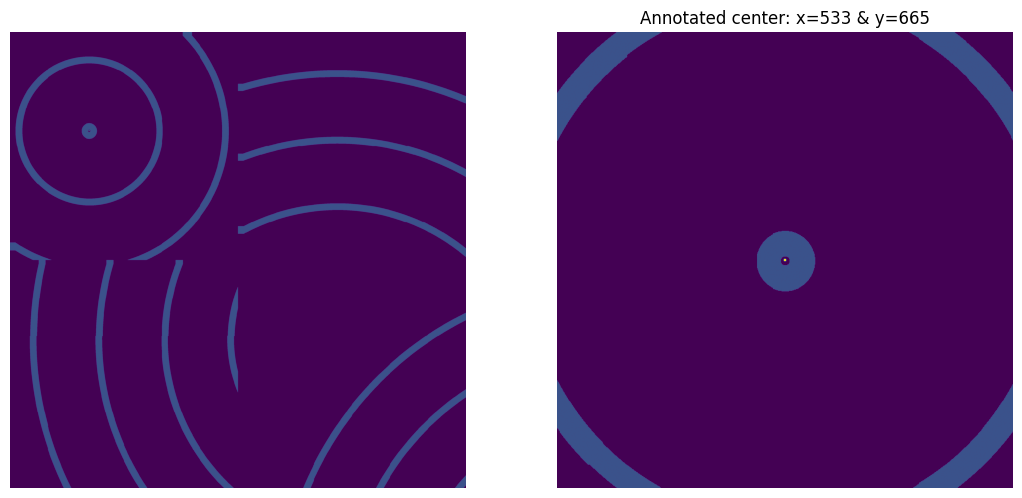

In [10]:
img = misc.rings(N=3072, cx=512, cy=650, n=6)

distance = 14000 #40 #mm

params = {'geo': 'nonplanar', 'opt': True, 'mode': 'virtual'} #, 'fill': False, 'susp': 10, 'gpu': 0 }

project = pi540D.dictionary540D(distance, params )

geometry = pi540D.geometry540D( project )
forw     = pi540D.forward540D(img,  geometry )

#dist=40
#ax = 520
#ay = 655

#dist=14000
ax = 533
ay = 665

#adding an roi-neighborhood just to 'see' the annotated point

roi                               = 2
forw[ay-roi:ay+roi,ax-roi:ax+roi] = 4

fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(131)
ax1.imshow(forw)
ax1.axis('off')

ax2 = fig.add_subplot(132)
roi = 400
ax2.imshow(forw[ay-roi:ay+roi,ax-roi:ax+roi])
ax2.set_title('Annotated center: x={} & y={}'.format(ax,ay))
ax2.axis('off')

----> 0.98


(-0.5, 399.5, 399.5, -0.5)

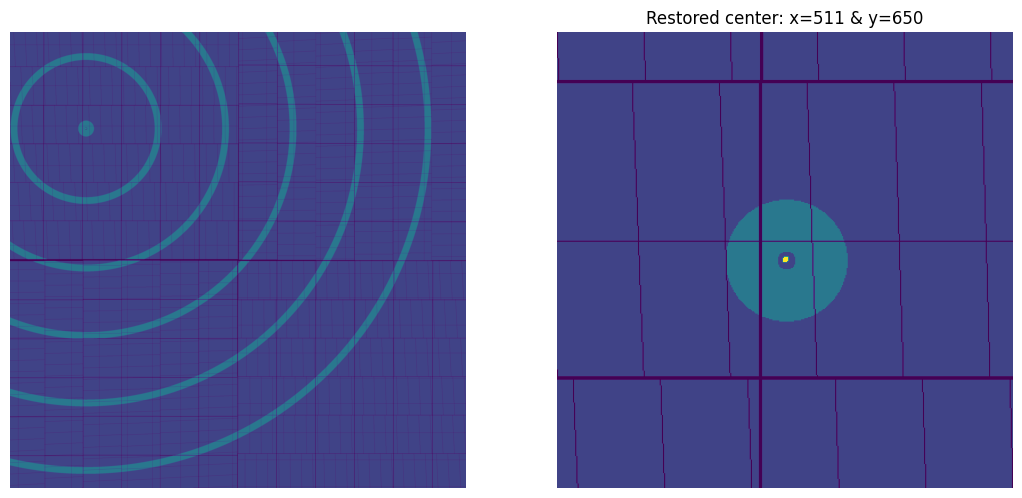

In [11]:
rx, ry = opt540D.mapping540D( ax, ay, project)

rest = pi540D.backward540D ( forw , geometry )

roi = 2
rest[ ry-roi:ry+roi, rx-roi:rx+roi  ] = 4

fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(131)
ax1.imshow(rest)
ax1.axis('off')

ax2 = fig.add_subplot(132)
roi = 200
ax2.imshow(rest[ry-roi:ry+roi,rx-roi:rx+roi])
ax2.set_title('Restored center: x={} & y={}'.format(rx,ry))
ax2.axis('off')

# Read and restore a volume 

# (a) Single volume

In [ ]:
from sscPimega import pi540D, opt540D

distance = 20000
params   = {'geo': 'nonplanar', 'opt': True, 'mode': 'virtual' ,'susp': 5}
project  = pi540D.dictionary540D(distance, params )
geometry = pi540D.geometry540D( project )

ax = 1426
ay = 1384
rx, ry = opt540D.mapping540D( ax, ay, project)

flat = h5py.File('/ibira/lnls/beamlines/caterete/apps/scans/FF/2023-01-18-FF6keV.hdf5')['entry/data/data'][0,0,:,:]
bkg  = h5py.File('/ibira/lnls/beamlines/caterete/proposals/20230614/data/3Dcdi/logo3Dcdi_bkg_0001.hdf5')['entry/data/data'][0,0,:,:]
mask = h5py.File('/ibira/lnls/beamlines/caterete/apps/scans/mask/basemask_150223_tiago2.hdf5')['entry/data/data'][0,0,:,:]

dic = {}
dic['path']     = "/ibira/lnls/beamlines/caterete/proposals/20230614/data/3Dcdi/logo3Dcdi_0000.hdf5"
dic['outpath']  = "/home/ABTLUS/eduardo.miqueles/test/"
dic['order']    = "yx"
dic['rank']     = "ztyx"
dic['dataset']  = "entry/data/data"
dic['gpus']     = [5]
dic['init']     = 0
dic['final']    = -1
dic['saving']   = 1
dic['timing']   = 1
dic['blocksize']= 10
dic['daxpy']    = [-1, bkg]
dic['geometry'] = geometry
dic['roi']      = 512
dic['center']   = [rx, ry]
dic['flat']     = flat
dic['empty']    = numpy.zeros([3072,3072])
dic['mask']     = mask

start = time.time()

uid, nimgs = pi540D.ioSet_Backward540D( dic )

output = pi540D.ioGet_Backward540D( dic, uid, nimgs )

pi540D.ioClean_Backward540D( dic, uid )

elapsed = time.time() - start

print('Elapsed: {}'.format(elapsed))

# (b) Mutiple volumes

In [ ]:
from sscPimega import pi540D

distance = 20000
params   = {'geo': 'nonplanar', 'opt': True, 'mode': 'virtual' ,'susp': 5}
project  = pi540D.dictionary540D(distance, params )
geometry = pi540D.geometry540D( project )

datapath = '/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/data/ptycho3d/glass21/'

dic = {}
dic['path']     = sorted( glob.glob( datapath + '/scans/*.hdf5') )
dic['outpath']  = "/home/ABTLUS/eduardo.miqueles/test/"
dic['order']    = "yx"
dic['rank']     = "ztyx"
dic['dataset']  = "entry/data/data"
dic['gpus']     = [2,3,4,5]
dic['init']     = 0
dic['final']    = -1
dic['saving']   = 1
dic['timing']   = 1
dic['blocksize']= 10
dic['geometry'] = geometry
dic['roi']      = 256
dic['center']   = [1328,1450]
dic['flat']     = h5py.File( datapath + '/images/flat.hdf5','r')['entry/data/data'][0,0,:,:]
dic['empty']    = h5py.File( datapath + '/images/empty.hdf5','r')['entry/data/data'][0,0,:,:]

start = time.time()

info = pi540D.ioSetM_Backward540D( dic )

output = pi540D.ioGetM_Backward540D( dic, info, 3)

pi540D.ioCleanM_Backward540D( dic, info )

elapsed = time.time() - start

print('Elapsed: {}'.format(elapsed))